In [1]:
import cv2
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from PIL import Image
import json
import os
import re
import easyocr

C:\Users\User\anaconda3\envs\medical_form\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## after fine-tunnig YOLOv8 model we are going to extract text using the bounding boxes predicted

## loading fine tuned model and creating the class names to be predicted as bounding box 

In [2]:
import cv2
import os
from ultralytics import YOLO

# Load the trained YOLOv8 model
model_path = "runs/detect/medical_form_yolo_star_bh_cnam_30_epoch8/weights/best.pt"
model = YOLO(model_path)

# Define class names (must match the order in data.yaml)
class_names = [
    "nom et prenom de adherent",
    "matricule cnam",
    "matricule de adherent",
    "addresse de ladherent",
    "numero cin ou passeport",
    "nom et prenom du malade",
    "date de naissance",
    "date",
    "designation",
    "honoraire",
    "id"
]



## predicting bounding boxes

In [3]:
# Path to the new image for prediction
image_path = "dataset/images/test/cnam_front_V9THV6.jpg"  # Replace with the path to your new image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")

# Run inference
results = model(image, imgsz=640, device=None)  # Use GPU (device=0); set to None for CPU



0: 480x640 2 nom et prenom de adherents, 1 matricule de adherent, 1 addresse de ladherent, 2 nom et prenom du malades, 1 date de naissance, 1 id, 91.0ms
Speed: 3.0ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


## saving predictions in a folder named predictions

In [4]:
# Create output folder for annotated images and cropped regions
output_folder = "predictions"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Process the detected bounding boxes
crop_counter = 1
for result in results:
    boxes = result.boxes.xyxy  # Get bounding boxes in [x_min, y_min, x_max, y_max] format
    confidences = result.boxes.conf  # Get confidence scores
    class_ids = result.boxes.cls  # Get class IDs

    for box, conf, cls_id in zip(boxes, confidences, class_ids):
        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, box)
        class_id = int(cls_id)
        label = class_names[class_id]
        confidence = float(conf)
        print (f"Confidence is : {confidence}")
        # # Apply 20px vertical padding for cropping
        # height, width = image.shape[:2]
        # padding = 0
        # x1 = max(0, x1)
        # x2 = min(width, x2)
        # y1 = max(0, y1 - padding)
        # y2 = min(height, y2 + padding)

        # Crop the detected region
        if x2 > x1 and y2 > y1:
            cropped_image = image[y1:y2, x1:x2]
            
            # Save the cropped image
            output_filename = f"{label.replace(' ', '_')}_{crop_counter}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, cropped_image)
            print(f"Saved cropped region to {output_path}")
            crop_counter += 1

# # Save the annotated image
# image_filename = os.path.basename(image_path)
# annotated_image_path = os.path.join(output_folder, f"annotated_{image_filename}")
# cv2.imwrite(annotated_image_path, image)
# print(f"Saved annotated image to {annotated_image_path}")


Confidence is : 0.9657264351844788
Saved cropped region to predictions\id_1.jpg
Confidence is : 0.9542441964149475
Saved cropped region to predictions\matricule_de_adherent_2.jpg
Confidence is : 0.9476297497749329
Saved cropped region to predictions\date_de_naissance_3.jpg
Confidence is : 0.9425316452980042
Saved cropped region to predictions\addresse_de_ladherent_4.jpg
Confidence is : 0.9274941086769104
Saved cropped region to predictions\nom_et_prenom_de_adherent_5.jpg
Confidence is : 0.9231452345848083
Saved cropped region to predictions\nom_et_prenom_de_adherent_6.jpg
Confidence is : 0.9180969595909119
Saved cropped region to predictions\nom_et_prenom_du_malade_7.jpg
Confidence is : 0.8897681832313538
Saved cropped region to predictions\nom_et_prenom_du_malade_8.jpg


## extract text using TrOCR

In [5]:
import os
import cv2
import easyocr

def detect_and_save_word(image_path, lang='fr', output_dir="predictions_cropped"):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Create EasyOCR reader
    reader = easyocr.Reader([lang], gpu=False)

    # Run OCR
    results = reader.readtext(img, detail=1, paragraph=False)

    # Create output dir
    os.makedirs(output_dir, exist_ok=True)

    if len(results) == 0:
        print("No text detected.")
        return

    # Only process the first detected word
    (bbox, text, prob) = results[0]
    (top_left, _, bottom_right, _) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

    word_img = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    if word_img.shape[0] > 0 and word_img.shape[1] > 0:
        filename = os.path.splitext(os.path.basename(image_path))[0]
        output_path = os.path.join(output_dir, f"{filename}_cropped.jpg")
        cv2.imwrite(output_path, word_img)
        print(f"Detected word: {text} (Confidence: {prob:.2f})")
        print(f"Saved to: {output_path}")
    else:
        print("Detected bounding box was empty.")





In [6]:
# Loop through each file in the folder
for filename in os.listdir("predictions"):
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
        image_path = os.path.join("predictions", filename)
        detect_and_save_word(image_path)

Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.


Detected word: 16S, (Confidence: 0.33)
Saved to: predictions_cropped\addresse_de_ladherent_4_cropped.jpg


Using CPU. Note: This module is much faster with a GPU.


Detected word: 11 08178} (Confidence: 0.52)
Saved to: predictions_cropped\date_de_naissance_3_cropped.jpg


Using CPU. Note: This module is much faster with a GPU.


Detected word: 01708094 (Confidence: 0.44)
Saved to: predictions_cropped\id_1_cropped.jpg


Using CPU. Note: This module is much faster with a GPU.


Detected word: 40001044 (Confidence: 0.16)
Saved to: predictions_cropped\matricule_de_adherent_2_cropped.jpg


Using CPU. Note: This module is much faster with a GPU.


Detected word: 5Q/AA (Confidence: 0.31)
Saved to: predictions_cropped\nom_et_prenom_de_adherent_5_cropped.jpg


Using CPU. Note: This module is much faster with a GPU.


Detected word: Bectielou (Confidence: 0.12)
Saved to: predictions_cropped\nom_et_prenom_de_adherent_6_cropped.jpg


Using CPU. Note: This module is much faster with a GPU.


Detected word: re uelou (Confidence: 0.13)
Saved to: predictions_cropped\nom_et_prenom_du_malade_7_cropped.jpg
Detected word: Aiha (Confidence: 0.35)
Saved to: predictions_cropped\nom_et_prenom_du_malade_8_cropped.jpg


C:\Users\User\anaconda3\envs\medical_form\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\User\anaconda3\envs\medical_form\lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length

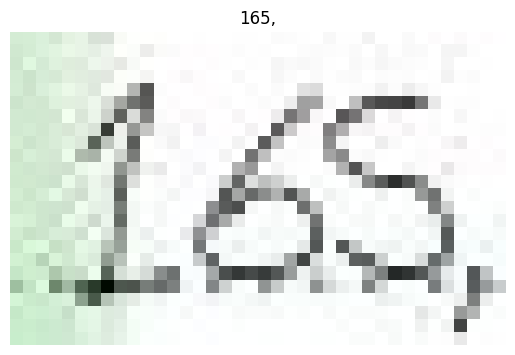

Extracted text from addresse_de_ladherent_4_cropped.jpg: 165,


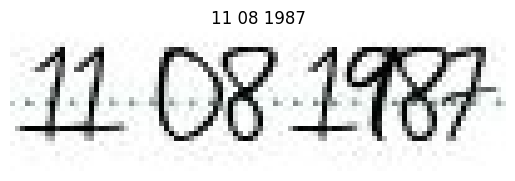

Extracted text from date_de_naissance_3_cropped.jpg: 11 08 1987


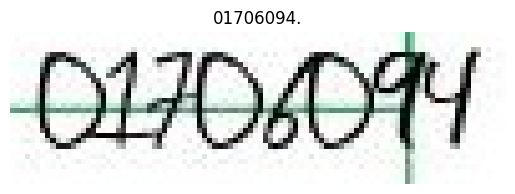

Extracted text from id_1_cropped.jpg: 01706094.


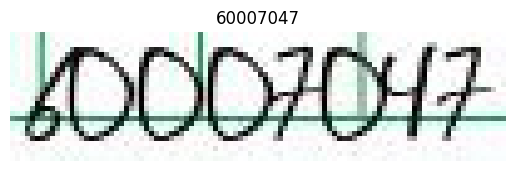

Extracted text from matricule_de_adherent_2_cropped.jpg: 60007047


In [ ]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Define paths
predictions_folder = "predictions_cropped"
output_json_path = os.path.join(predictions_folder, "extracted_text.json")

# Load the TrOCR model and processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

# Dictionary to store extracted text
extracted_texts = {}

# Iterate over all images in the predictions folder
for image_name in os.listdir(predictions_folder):
    if not image_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue  # Skip non-image files

    image_path = os.path.join(predictions_folder, image_name)
    
    try:
        # Load the image
        image = Image.open(image_path).convert("RGB")
        
        # Preprocess the image
        pixel_values = processor(images=image, return_tensors="pt").pixel_values

        # Generate text
        generated_ids = model.generate(pixel_values)

        # Decode the generated IDs to text
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # Save to dictionary
        extracted_texts[image_name] = predicted_text

        # Display the image with the extracted text as the title
        plt.imshow(image)
        plt.title(predicted_text, fontsize=12)
        plt.axis('off')
        plt.show()

        print(f"Extracted text from {image_name}: {predicted_text}")

    except Exception as e:
        print(f"Error processing {image_name}: {str(e)}")
        extracted_texts[image_name] = "Error: Could not extract text"

# # Save the extracted texts to a JSON file
# with open(output_json_path, "w", encoding="utf-8") as f:
#     json.dump(extracted_texts, f, ensure_ascii=False, indent=4)

# print(f"Saved extracted texts to {output_json_path}")
